<center><h1>ЛР 3 - Метод Ньютона и обобщения</h1><center>
<center>Леховицкий Дмитрий, ст. гр. ПМ-15-1<center>
<center>Вариант №7<center>

In [1]:
# для вычислений
import numpy as np
from numpy import dot
from numpy import array
from numpy.linalg import inv
from scipy.optimize import minimize 
from scipy.optimize import OptimizeResult
from scipy.optimize import minimize_scalar

# для построения графиков
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn")
plt.rc("text", usetex=True)
plt.rc("font", serif="serif")

In [2]:
# непосредственно построение графиков
def plot_surface(ff, xx, yy):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, ff, alpha=0.6)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f(x_1, x_2)$')
    return fig, ax

# пора всё это дело уже в отдельный файл вынести
def plot_contour(ff, xx, yy, levels):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    CS = ax.contour(xx, yy, ff, levels, colors=sns.color_palette("Blues"), alpha=0.6)
    ax.set_aspect(1)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.clabel(CS, levels, fmt="%.2f")
    return fig, ax

## План и постановка задачи 

Мы вновь рассматриваем численные методы решения задачи безусловной оптимизации. В этот раз мы рассмотрим методы второго порядка (те, что используют вторые производные целевой функции с целью построения минимизирующей последовательности).  

Методы второго порядка можно поделить на такие группы: 
1. Метод Ньютона и его обобщения - явно используют матрицу, обратную матрице Гессе, для улучшения сходимости;

2. Метод Левенберга-Маркардта - является комбинацией метода Ньютона и метода градиентного спуска;

3. Квазиньютоновские методы ([Wiki](https://ru.wikipedia.org/wiki/%D0%9A%D0%B2%D0%B0%D0%B7%D0%B8%D0%BD%D1%8C%D1%8E%D1%82%D0%BE%D0%BD%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B)) - вместо явного обращения матрицы Гессе аппроксимируется матрица $[f^{\prime\prime}(\mathbf{x})]^{-1}$. К ним относятся такие известные алгоритмы:

    - Девидон-Флетчер-Пауэлл;
   
    - Бройден-Флетчер-Гольдфарб-Шенно (BFGS, достаточно часто встречающееся название).

Пока что рассмотрим метод Ньютона и два его обобщения.

В качестве примера рассматриваем всё ту же функцию двух переменных ($\mathbf{x}=(x_1, x_2)$): 

$$f(x_1, x_2) = x_1^3 + 8x_2^3-6x_1 x_2 + 1.$$

Её градиент:

$$\nabla f(x_1, x_2) = \left[\begin{array}{c} 3x_1^2 - 6x_2 \\ 24x_2^2 - 6x_1 \end{array}\right],$$

и Гессиан:

$$H(x_1, x_2) = \left[\begin{array}{cc} 6x_1 & -6 \\ -6 & 48x_2\end{array}\right]$$

In [3]:
def f(x):
    x1, x2 = x
    return x1**3 + 8*x2**3 - 6*x1*x2 + 1 

def grad_f(x):
    x1, x2 = x
    grad = np.zeros_like(x)
    grad[0] =  3*x1**2 - 6*x2
    grad[1] = 24*x2**2 - 6*x1
    return grad

def hess_f(x):
    x1, x2 = x
    hess = array([[6*x1, -6], [-6, 48*x2]])
    return hess

In [4]:
delta = 0.025
x1 = np.arange(-0.5, 3+delta, delta)
x2 = np.arange(-0.5, 1.5+delta, delta)
xx1, xx2 = np.meshgrid(x1, x2)
ff = f([xx1, xx2])

<IPython.core.display.Javascript object>


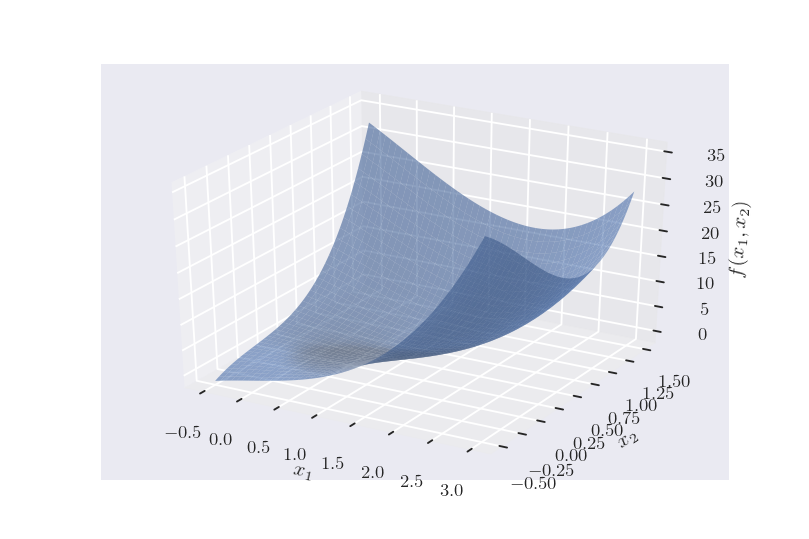

In [5]:
plot_surface(ff, xx1, xx2);

<IPython.core.display.Javascript object>


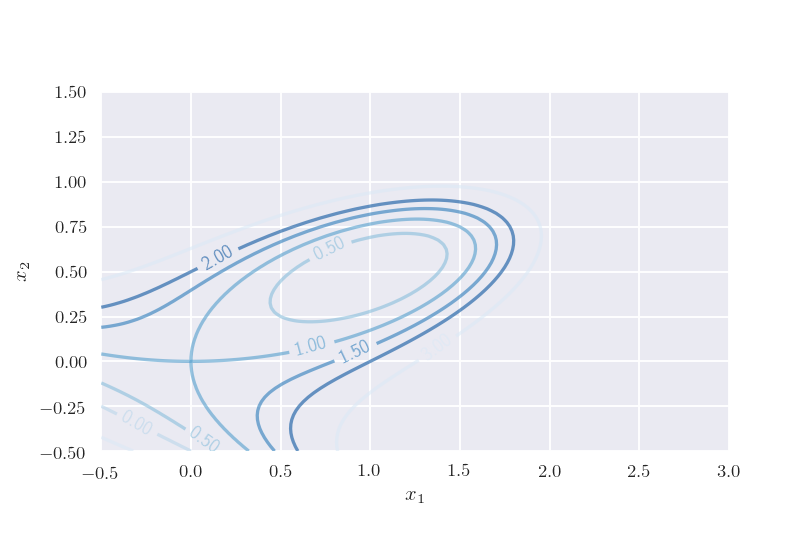

In [6]:
plot_contour(ff, xx1, xx2, 
             levels=[-1, 0, 0.5, 1, 1.5, 2., 3]);

Речь всё так же идёт о построении минимизирующей последовательности, поэтому нам надо выбрать какую-то точку, из которой буем стартовать. Возьмём ту же, что и ранее:

In [7]:
x0 = array([2, 1])

## Итак, Ньютон 

Формула итерационного шага для метода Ньютона имеет вид

$$\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)}-\left[f^{\prime\prime}(\mathbf{x^{(k)}})\right]^{-1} f^{\prime}(\mathbf{x^{(k)}}).$$

Откуда она взялась: аппроксимируем целевую функцию квадратичной, воспользовавшись разложением в ряд Тейлора в окрестности точки $\mathbf{x}^{(k)}$:

$$ f(\mathbf{x}) \approx f(\mathbf{x}^{(k)}) + (\mathbf{x}-\mathbf{x}^{(k)})^T f^{\prime}(\mathbf{x}^{(k)}) + \frac{1}{2}(\mathbf{x}-\mathbf{x}^{(k)})^T f^{\prime\prime}(\mathbf{x}^{(k)})(\mathbf{x}-\mathbf{x}^{(k)}),$$

и выберем $k+1$-е приближение как минимум этой гиперпараболы. Для этого мы, как обычно, дифференцируем эту функцию по $\mathbf{x}$, радуемся, что она именно квадратична, и градиент от неё считается крайне легко ($f^{\prime\prime}(\mathbf{x}^{(k)})(\mathbf{x}-\mathbf{x}^{(k)}) + f^{\prime}(\mathbf{x}^{(k)})$), приравниваем его к нулю, и получаем как раз формулу итерационного шага (она действительно обеспечивает минимум ввиду выпуклости квадратичной функции). 

_Немного о скорости сходимости, хороших свойствах вроде справляемости с овражностью и т.д._

Реализовываем по уже известной схеме, взаимодействуя с `scipy.optimize`:

In [8]:
def newton(func, x0, jac, hess, tol, args=(), **options):
    k = 0
    X = [x0]
    F = [func(x0)] 
    J = [jac(x0)]  # вообще их историю 
    H = [hess(x0)] # можно и не хранить
    while np.linalg.norm(J[k]) >= tol:
        hk = -dot(inv(H[k]), J[k])
        X.append(X[k]+hk)
        F.append(func(X[k+1]))
        J.append(jac(X[k+1]))
        H.append(hess(X[k+1]))
        k += 1
    
    return OptimizeResult(
        x=X[-1], fun=F[-1], jac=J[-1], hess=H[-1],
        x_hist=np.c_[X].T, f_hist=array(F), 
        nit=k)

In [9]:
%timeit minimize(f, x0, method=newton, jac=grad_f, hess=hess_f, tol=0.001, options=dict())

256 µs ± 58.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
res = minimize(f, x0, method=newton, jac=grad_f, hess=hess_f, tol=0.001, options=dict())
x1_hist, x2_hist = res.x_hist
print("Optimal point: (%.6f, %.6f).\nOptimal value: %.6f." % (res.x[0], res.x[1], res.fun))
print("Number of iterations for Newton's method: %d." % res.nit)

Optimal point: (1.000015, 0.500008).
Optimal value: 0.000000.
Number of iterations for Newton's method: 4.


На графике видно типичное поведение метода Ньютона: сперва заскочить почти в центр оврага огромным шагом, а потом уже оптимизировать небольшими смещениями.

<IPython.core.display.Javascript object>


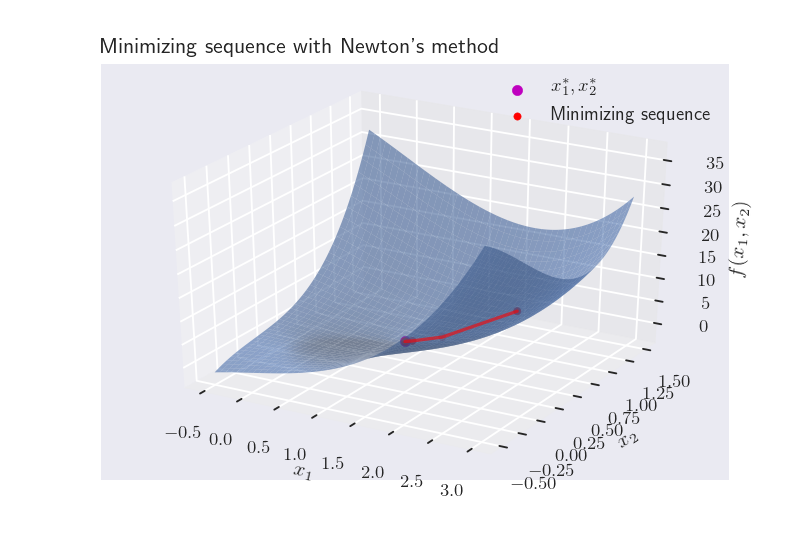

In [11]:
fig, ax = plot_surface(ff, xx1, xx2);
ax.scatter(res.x[0], res.x[1], f([res.x[0], res.x[1]]), c='m', s=30, label='$x_1^{*}, x_2^{*}$')
ax.scatter(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', alpha=0.6)
ax.set_title("Minimizing sequence with Newton's method", loc='left');
ax.legend(loc='best');

<IPython.core.display.Javascript object>


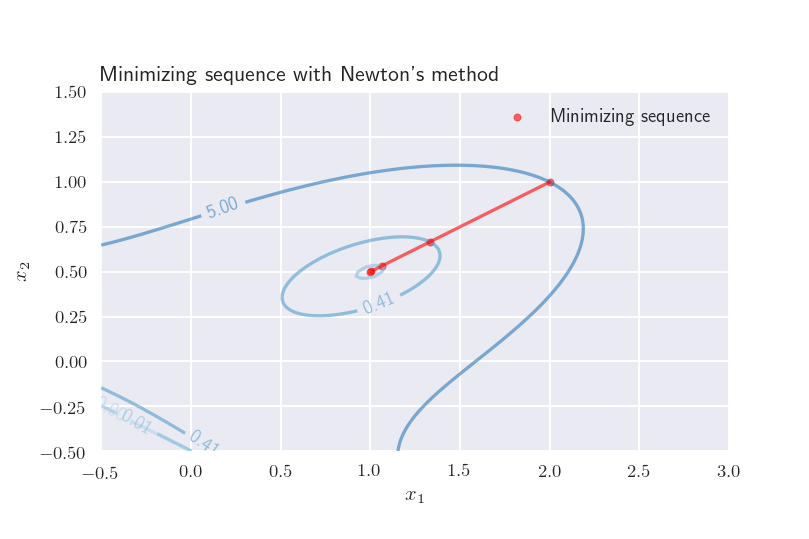

In [12]:
fig, ax = plot_contour(ff, xx1, xx2, levels=np.sort(res.f_hist))
ax.scatter(x1_hist, x2_hist, c='r', alpha=0.6, s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, c='r', alpha=0.6)
ax.set_title("Minimizing sequence with Newton's method", loc='left');
ax.legend(loc='best');

## Обобщения 

В общем случае итерационная формула метода Ньютона не даёт нам сходимости за 1 шаг, поэтому иногда может иметь смысл длину шага контролировать, чтобы не ускакать слишком далеко:

$$\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)}-\alpha_k \left[f^{\prime\prime}(\mathbf{x^{(k)}})\right]^{-1} f^{\prime}(\mathbf{x^{(k)}}).$$

$\alpha_k$ выбирают исходя из какого-то условия оптимальности (как и ранее, дробление пополам или же минимизация одномерной функции $\Phi(\alpha)=f(\mathbf{x}^{(k+1)}(\alpha))$). Так мы и пришли к методу Ньютона-Рафсона.

#### Обобщение раз 

In [13]:
def mod_newton1(func, x0, jac, hess, tol, args=(), alpha0=1, **options):
    k = 0
    X = [x0]
    F = [func(x0)]
    J = [jac(x0)]
    H = [hess(x0)]
    while np.linalg.norm(J[k]) >= tol:
        alphak = alpha0
        hk = -dot(inv(H[k]), J[k])
        X.append(X[k]+alphak*hk)
        while func(X[k+1]) >= F[k]:
            alphak /= 2
            X[k+1] = X[k] - alphak*hk
        F.append(func(X[k+1]))
        J.append(jac(X[k+1]))
        H.append(hess(X[k+1]))
        k += 1
    
    return OptimizeResult(
        x=X[-1], fun=F[-1], jac=J[-1], hess=H[-1],
        x_hist=np.c_[X].T, f_hist=array(F),
        nit=k)

In [14]:
%timeit minimize(f, x0, method=mod_newton1, jac=grad_f, hess=hess_f, tol=0.001, options=dict(alpha0=0.5))

744 µs ± 62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
res = minimize(f, x0, method=mod_newton1, jac=grad_f, hess=hess_f, tol=0.001, options=dict(alpha0=0.5))
x1_hist, x2_hist = res.x_hist
print("Optimal point: (%.6f, %.6f).\nOptimal value: %.6f." % (res.x[0], res.x[1], res.fun))
print("Number of iterations for the first modification of Newton's method: %d." % res.nit)

Optimal point: (1.000099, 0.500050).
Optimal value: 0.000000.
Number of iterations for the first modification of Newton's method: 15.


Такой себе результат получился. И по времени, и по количеству итераций. Не будем график строить.

#### Обобщение два

In [16]:
def mod_newton2(func, x0, jac, hess, tol, args=(), alpha_max=1, **options):
    k = 0
    X = [x0]
    F = [func(x0)]
    J = [jac(x0)]
    H = [hess(x0)]
    while np.linalg.norm(J[k]) >= tol:
        hk = -dot(inv(H[k]), J[k])
        Phi = lambda alpha: func(X[k] + alpha*hk)
        res = minimize_scalar(Phi, bounds=(0, alpha_max), method='bounded', 
                              options=dict(xatol=tol))
        alphak = res.x
        X.append(X[k]+alphak*hk)
        F.append(func(X[k+1]))
        J.append(jac(X[k+1]))
        H.append(hess(X[k+1]))
        k += 1
    
    return OptimizeResult(
        x=X[-1], fun=F[-1], jac=J[-1], hess=H[-1],
        x_hist=np.c_[X].T, f_hist=array(F),
        nit=k)

In [17]:
%timeit minimize(f, x0, method=mod_newton2, jac=grad_f, hess=hess_f, tol=0.001, options=dict(alpha_max=2))

420 µs ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
res = minimize(f, x0, method=mod_newton2, jac=grad_f, hess=hess_f, tol=0.001, options=dict(alpha0=0.5))
x1_hist, x2_hist = res.x_hist
print("Optimal point: (%.6f, %.6f).\nOptimal value: %.6f." % (res.x[0], res.x[1], res.fun))
print("Number of iterations for the second modification of Newton's method: %d." % res.nit)

Optimal point: (1.000017, 0.500009).
Optimal value: 0.000000.
Number of iterations for the second modification of Newton's method: 4.


Итераций значительно меньше, чем в случае первой модификации (всё равно больше 1, как и ожидалось). График с решением:

<IPython.core.display.Javascript object>


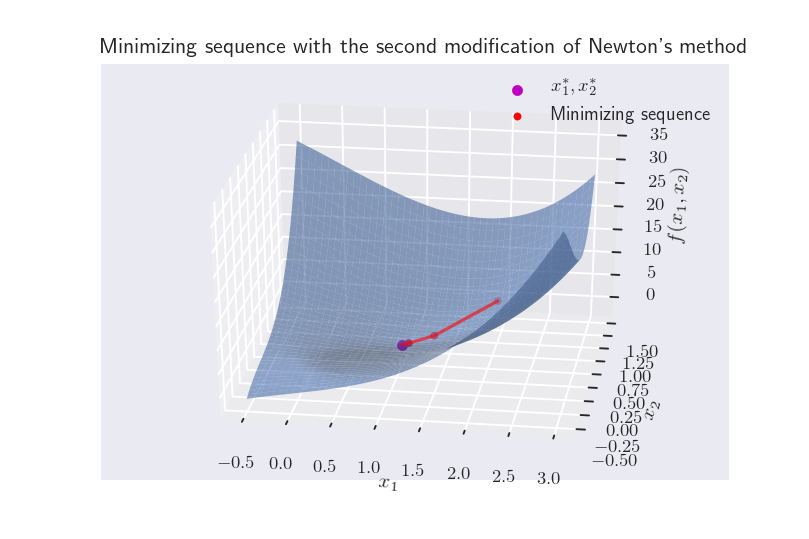

In [19]:
fig, ax = plot_surface(ff, xx1, xx2);
ax.scatter(res.x[0], res.x[1], f([res.x[0], res.x[1]]), c='m', s=30, label='$x_1^{*}, x_2^{*}$')
ax.scatter(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', alpha=0.6)
ax.set_title("Minimizing sequence with the second modification of Newton's method", loc='left');
ax.legend(loc='best');

<IPython.core.display.Javascript object>


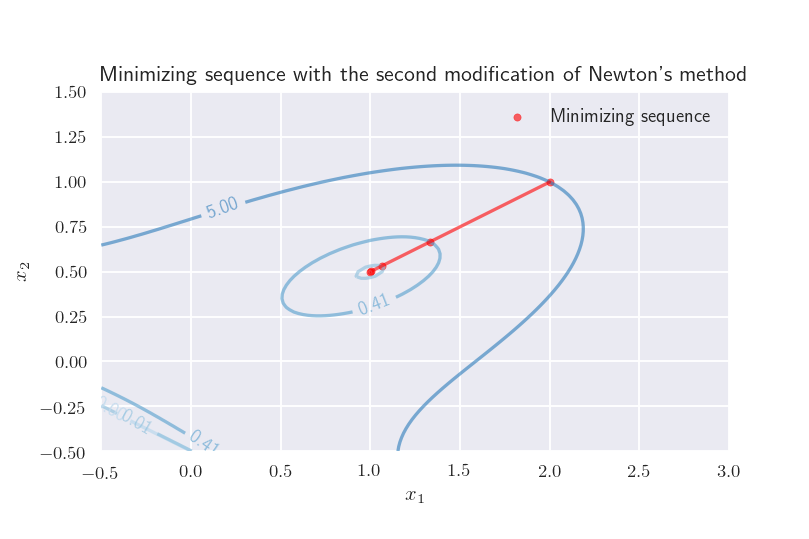

In [20]:
fig, ax = plot_contour(ff, xx1, xx2, levels=np.sort(res.f_hist))
ax.scatter(x1_hist, x2_hist, c='r', alpha=0.6, s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, c='r', alpha=0.6)
ax.set_title("Minimizing sequence with the second modification of Newton's method", loc='left');
ax.legend(loc='best');

## Мини-вывод

Сейчас мы посмотрели на метод Ньютона - один из ярких представителей методов второго порядка, и увидели основные преимущества: использование вторых производных позволяет очень сильно уточнить процесс сходимости, избежать блуждания зиг-загом вдоль направления локального минимума в случае овражности целевой функции, скорости (почти в 5 раз быстрее, чем самый простой метод первого порядка, даже с учётом обращения матрицы).

Недостатки его так же предельно ясны: необходимость хранить (и тем более обращать) Гессиан на каждой итерации. Во-первых, он может не существовать или быть неизвестным, во-вторых, для числа переменных, превосходящего 2, мы уже не увидим такой доминации над градиентными методами. Обе проблемы можно попробовать решить, обратившись к квазиньютоновским методам (для которых, вообще говоря, хотелось бы создать отдельный ноутбук). 

В следующий же раз мы продолжим с численными методами оптимизации без ограничений, рассмотрев группу методов "сопряжённых градиентов" (или направлений).